In [70]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
!pip install pandas nltk spacy
!pip install praw
!pip install --upgrade git+https://github.com/praw-dev/asyncpraw.git
!python -m spacy download en_core_web_sm
!pip install vaderSentiment pandas
nltk.download('vader.lexicon')
nltk.download('stopwords')
nltk.download('punkt')

  Cloning https://github.com/praw-dev/asyncpraw.git to /tmp/pip-req-build-tesx2acq
  Running command git clone --filter=blob:none --quiet https://github.com/praw-dev/asyncpraw.git /tmp/pip-req-build-tesx2acq
  Resolved https://github.com/praw-dev/asyncpraw.git to commit 285063ddee81dda617c87168139331ef832f9c36
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Error loading vader.lexicon: Package 'vader.lexicon' not
[nltk_data]     found in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [71]:
import praw
from praw.models import MoreComments

reddit= praw.Reddit(client_id='QRrEg66rbgAkUcuHX8d2Kw',
                     client_secret='aPrEF_1pq5QRfgdM39wH7Hz6ickoxQ',
                     user_agent='Mayeil17',
                     username='dataset scrape')

url = "https://www.reddit.com/r/soccer/comments/mtmrzx/simon_stone_esl_statement_twelve_of_europes/"

post = reddit.submission(url=url)



In [72]:

reddit_comments = []
for top_level_comment in post.comments:
    if isinstance(top_level_comment, MoreComments):
        continue
    reddit_comments.append(top_level_comment.body)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [73]:
df = pd.DataFrame(columns=['data', 'label',])
df.head

<bound method NDFrame.head of Empty DataFrame
Columns: [data, label]
Index: []>

In [74]:
df.to_csv('data.csv',header=False, encoding='utf-8', index=False)

In [75]:
df = pd.DataFrame(reddit_comments)
df.head(10)
df.to_csv("data.csv",index=False)

In [76]:
nlp = spacy.load('en_core_web_sm')

df = pd.read_csv('data.csv')


def clean_reddit_text(text):

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\b[rRuU]/\w+\b', '', text)

    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)

    text = re.sub(r'\s+' ,' ',text).strip()
    return text


df['cleaned_text'] = df['0'].apply(clean_reddit_text)


slang_dict = {
    "ftw": "for the win",
    "og": "own goal",
    "gf": "good fight",
    "gg": "good game"
}

def expand_slang(text):
    words = text.split()
    words = [slang_dict.get(word.lower(), word) for word in words]
    return ' '.join(words)

df['cleaned_text'] = df['cleaned_text'].apply(expand_slang)


stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)


def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)


df[['0', 'cleaned_text', 'lemmatized_text']].to_csv(
    'cleaned_reddit_data.csv',
    index=False
)

print("Cleaning complete! Saved to cleaned_reddit_data.csv")

Cleaning complete! Saved to cleaned_reddit_data.csv


In [77]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd


df = pd.read_csv('cleaned_reddit_data.csv')

df['sentiment'] = df['cleaned_text'].apply(
    lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound']
)


df['sentiment_label'] = df['sentiment'].apply(
    lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
)


df.to_csv('sentiment_results.csv', index=False)
print("Done! Check sentiment_results.csv")

Done! Check sentiment_results.csv


<Axes: xlabel='sentiment_label'>

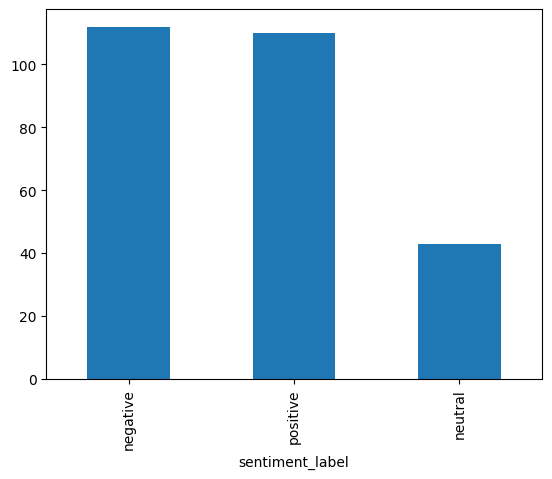

In [78]:
df['sentiment_label'].value_counts().plot(kind='bar')

In [79]:
print(df['sentiment_label'].value_counts(normalize=True) * 100)

sentiment_label
negative    42.264151
positive    41.509434
neutral     16.226415
Name: proportion, dtype: float64
